In [11]:
import pandas as pd
import numpy as np
import os
import pickle
import torchxrayvision as xrv
import torch
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func
import torchxrayvision as xrv
import sys
from torch.utils.data import DataLoader
import cv2
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display
import matplotlib.pyplot as plt
import pickle

In [12]:
path = "/om/user/shobhita/src/chexpert/output/output_10/results/"
filenames = os.listdir(path)

In [3]:
filenames

['2_True_results.pkl',
 '1_False_results.pkl',
 '1_True_results.pkl',
 '1_False_augmented_results.pkl',
 '2_False_augmented_results.pkl',
 '2_False_results.pkl']

In [13]:
results = {}
for file in filenames:
    with open(path + file, "rb") as handle:
        res = pickle.load(handle)
        results[file.split(".")[0]] = res

In [14]:
for name, val in results.items():
    print(name, val["validation_loss"], val["best_epoch"])

2_True_results 0.1821520689975571 7
1_False_results 0.3864795988256281 9
1_True_results 0.16805715620720468 8
2_True_results2 0.37792219585842557 10
1_False_augmented_results 0.38605717041275717 16
1_True_results2 0.3703241636244099 7
1_False_results2 0.3907931842587211 10
2_False_augmented_results 0.3964883078421865 8
2_False_results 0.3880809375217983 8
2_False_results2 0.40265254250594545 10


In [6]:
best_without_gan = "2_False_results"
best_with_gan = "1_True_results"

results_df = pd.DataFrame({"with_gan":pd.Series(results[best_with_gan]["auc"]), 
              "without_gan":pd.Series(results[best_without_gan]["auc"])})

In [7]:
results_df

,with_gan,without_gan
AUROC mean,0.731304,NaN
Atelectasis,0.698644,0.684906
Cardiomegaly,0.827037,0.810201
Consolidation,0.715451,0.666967
Edema,0.598261,0.569201
Enlarged Cardiomediastinum,0.670997,0.665251
Fracture,0.758133,0.722472
Lung Lesion,0.814183,0.789932
Lung Opacity,0.656555,0.650023
Pleural Effusion,0.750305,0.705977


# CAM Images

In [15]:
def load_data(path, dataset_size, train_filename):
    # add data augmentations transforms here
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
                                                xrv.datasets.XRayResizer(224)])
    # replace the paths for the dataset here
    print("\nUsing labels: {}".format(train_filename))

    d_chex_train = xrv.datasets.CheX_Dataset(imgpath=path,
                                       csvpath=path + train_filename,
                                       transform=transform, views=["PA", "AP"], unique_patients=False)
    d_chex_test = xrv.datasets.CheX_Dataset(imgpath=path,
                                       csvpath=path + "test_train_preprocessed.csv",
                                       transform=transform, views=["PA", "AP"], unique_patients=False)
    return d_chex_train, d_chex_test

In [16]:
full_labels = pd.read_csv("/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/train_preprocessed_subset_100_with_gan.csv")



In [17]:
gan_labels = full_labels[full_labels['ID'] == 65000]
gan_labels.to_csv("/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/train_preprocessed_subset_100_only_gan.csv")

In [18]:
def generate_featuremap_CAM(model_cut,model_full,unit_id,im_input):
    #Extract activation from model
    model_cut.eval()    
#     im = center_crop(im_input)
    activations = model_cut(im_input).squeeze() #2048 x h x w
    print(activations.shape)
    num_channels, height, width = activations.shape
    
    # TODO: convert the shape of the output (out variable) to (h*w) x c 
    # The .view() function and .transpose() functions will help
    activations_reshaped = torch.transpose(activations.view(num_channels, height*width), 0, 1)

    # TODO: Run the fully connected layer from resnet to compute the weighted average with activations as the input variable
    # out_final should be a h x w x 365 tensor. 
    out_final = [*list(model_full.children())][-1].forward((activations_reshaped)).view(height, width, -1)

    # TODO: obtain the class activation map for the corresponding unit_id
    # class_activation_maps should be a 365 x height x width tensor. 
    class_activation_maps = torch.transpose(torch.transpose(out_final, 0, 2), 1, 2)

    return class_activation_maps[unit_id]

def visualize_featuremap(im_input,feature_map,alpha=0.3):
    # Normalize to [0..1], with a little leeway (0.9999) in case feature_map has 0 range
    feature_map = feature_map/(feature_map.max()+1e-10)
    # Convert to numpy (detach() just seperates a tensor from the gradient)
    feat_numpy = feature_map.detach().numpy()
    # Resize the feature map to our original image size (our strided conv layers reduce the size of the image)
    feat_numpy = cv2.resize(feat_numpy,(im_input.shape[1],im_input.shape[0]))
    # Invert to make the heatmap look more natural
    map_t = 1-feat_numpy
    # Add an extra dimension to make this a [H,W,C=1] image 
    feat_numpy = np.expand_dims(feat_numpy, axis=2)
    
    # Convert to image (UINT8 from 0-255)
    map_t = 255*map_t
    map_t = map_t.astype(np.uint8)
    # Use a color map to change this from BW to a nice color
    map_t = cv2.applyColorMap(map_t, cv2.COLORMAP_JET)
    # Combine the heatmap with the original image so you can see which section of the image is activated
    im_final = np.multiply((alpha*im_input + (1-alpha)*map_t), feat_numpy) + np.multiply(im_input, 1-feat_numpy)
    # Return final visualization
    return im_final, map_t

In [19]:
def get_model():
    model = xrv.models.DenseNet(num_classes=13)
    print(model.classifier)
    return model

def get_trained_model(dataset_size, idx, with_gan):
    model_path = "/om/user/shobhita/src/chexpert/output/output_{}/models/".format(dataset_size)
    model_name = "densenet_{}_{}".format(idx, with_gan)
    model = get_model()
    print(model_path + model_name)
    model.load_state_dict(torch.load(model_path + model_name))
    return model

def get_data_loader(batch_size, dataset_size, filename):
    data_path = "/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/"
    dataset_train, dataset_test = load_data(data_path, dataset_size, filename)
    print(len(dataset_train))
    dataLoaderTrain = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True,  num_workers=3, pin_memory=True)
    return dataLoaderTrain

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def im_tensor_to_numpy(img_tensor):
    img = img_tensor.numpy()
    img_numpy = img.squeeze(0)
    img_numpy = np.transpose(img_numpy, (1,2,0))
    return img_numpy

def get_cam(img_tensor, trained_model, cat_index):
    model_cut = nn.Sequential(*list(trained_model.children())[:-1])
    feat = generate_featuremap_CAM(model_cut, trained_model, cat_index, img_tensor['img'])
    img_numpy = im_tensor_to_numpy(img_tensor['img'])
    im_result = visualize_featuremap(img_numpy,feat)
    return im_result

In [20]:
dataset_size = 100
idx = 2
batch_size = 1
categories = torch.tensor([3, 10, 11])

model_with_gan = get_trained_model(dataset_size, idx, with_gan=True)
model_no_gan = get_trained_model(dataset_size, idx, with_gan=False)


Linear(in_features=1024, out_features=13, bias=True)
/om/user/shobhita/src/chexpert/output/output_100/models/densenet_2_True
Linear(in_features=1024, out_features=13, bias=True)
/om/user/shobhita/src/chexpert/output/output_100/models/densenet_2_False


In [21]:
data_loader_gan = get_data_loader(batch_size, dataset_size, "train_preprocessed_subset_100_only_gan.csv")
data_loader_real = get_data_loader(batch_size, dataset_size, "train_preprocessed.csv")

Setting XRayResizer engine to cv2 could increase performance.

Using labels: train_preprocessed_subset_100_only_gan.csv
95000
Setting XRayResizer engine to cv2 could increase performance.

Using labels: train_preprocessed.csv
172214


### GAN-trained model on real data v. GAN data

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


(-0.5, 223.5, 223.5, -0.5)

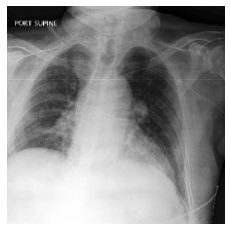

tensor([[1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.]])
torch.Size([1024, 7, 7])


(-0.5, 223.5, 223.5, -0.5)

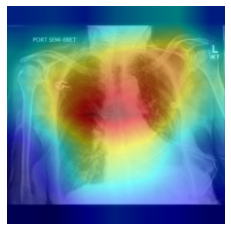

In [22]:
for gan_im in iter(data_loader_gan):
    if gan_im['lab'][0][3] == 1:
        break

print(gan_im['lab'])
plt.imshow(im_tensor_to_numpy(gan_im['img']), cmap="gray")
plt.axis("off")

gan_im_result, gan_color_map = get_cam(gan_im, model_with_gan, 3)
plt.imshow(im_tensor_to_numpy(gan_im['img']), cmap="gray")
plt.imshow(gan_color_map, alpha=0.5)
plt.axis("off")

tensor([[0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]])
torch.Size([1024, 7, 7])


(-0.5, 223.5, 223.5, -0.5)

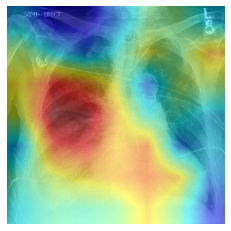

In [29]:
for real_im in iter(data_loader_real):
    if real_im['lab'][0][3] == 1:
        break

print(real_im['lab'])
plt.imshow(im_tensor_to_numpy(real_im['img']), cmap="gray")
plt.axis("off")
real_im_result, real_color_map = get_cam(real_im, model_with_gan, 3)
plt.imshow(im_tensor_to_numpy(real_im['img']), cmap="gray")
plt.imshow(real_color_map, alpha=0.5)
plt.axis("off")

## 1% gan v. real trained model on the same image

In [224]:
dataset_size = 1
idx = 2
batch_size = 1
categories = torch.tensor([3, 10, 11])

model_with_gan = get_trained_model(dataset_size, idx, with_gan=True)
model_no_gan = get_trained_model(dataset_size, idx, with_gan=False)

Linear(in_features=1024, out_features=13, bias=True)
/om/user/shobhita/src/chexpert/output/output_1/models/densenet_2_True
Linear(in_features=1024, out_features=13, bias=True)
/om/user/shobhita/src/chexpert/output/output_1/models/densenet_2_False


tensor([[0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.]])


(-0.5, 223.5, 223.5, -0.5)

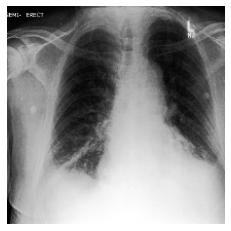

In [239]:
for real_im in iter(data_loader_real):
    if real_im['lab'][0][10] == 1:
        break

print(real_im['lab'])
plt.imshow(im_tensor_to_numpy(real_im['img']), cmap="gray")
plt.axis("off")


torch.Size([1024, 7, 7])


(-0.5, 223.5, 223.5, -0.5)

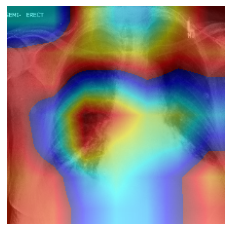

In [240]:
real_im_result, real_color_map = get_cam(real_im, model_no_gan, 10)
plt.imshow(im_tensor_to_numpy(real_im['img']), cmap="gray")
plt.imshow(real_color_map, alpha=0.5)
plt.axis("off")

torch.Size([1024, 7, 7])


(-0.5, 223.5, 223.5, -0.5)

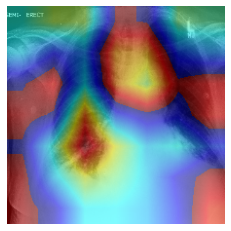

In [241]:
gan_im_result, gan_color_map = get_cam(real_im, model_with_gan, 10)
plt.imshow(im_tensor_to_numpy(real_im['img']), cmap="gray")
plt.imshow(gan_color_map, alpha=0.5)
plt.axis("off")

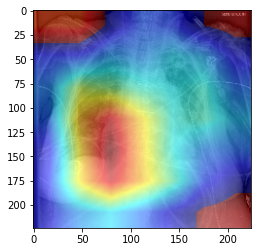

In [47]:
plt.imshow(im_tensor_to_numpy(im['img']), cmap="gray")
plt.imshow(color_map_no_gan, alpha=0.5)

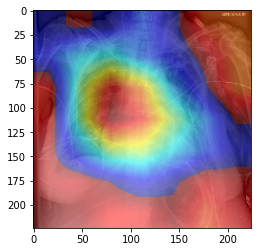

In [51]:
plt.imshow(im_tensor_to_numpy(im['img']), cmap="gray")
plt.imshow(color_map_no_gan, alpha=0.5)

In [145]:
(im_result_gan == im_result_no_gan).all()

False

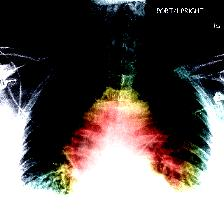

In [33]:
showarray(im_result_gan)

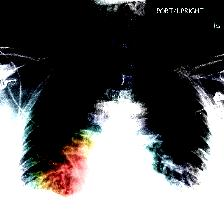

In [34]:
showarray(im_result_no_gan)

In [98]:
categories

tensor([ 3, 10, 11])

torch.Size([1024, 7, 7])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


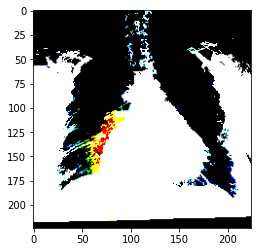

# Compiling results

In [20]:
results = {}
from statistics import mean
paths = {
    10: "output_10/results/",
    50: "output_50/results/",
    100: "output_100/results/",
    1: "output_1/results/"
}
cats = ["Lung Lesion", "Pleural Other", "Fracture"]
base_path = "/om/user/shobhita/src/chexpert/output/"
for size in [100]:
    output_path = base_path + paths[size]
    for with_gan in ["False"]:
        max_id = 0
        max_acc = 0
        for i in range(1,3):
            name = "{}_{}_augmented_results.pkl".format(i, with_gan)
            with open(output_path + name, "rb") as handle:
                results = pickle.load(handle)
                res = {key: val[0] for key, val in results['auc'].items() if key in cats}
                print("\n{}: {}, {}".format(size, name, mean(list(res.values()))))
                print(res)

    

FileNotFoundError: [Errno 2] No such file or directory: '/om/user/shobhita/src/chexpert/output/output_100/results/1_False_augmented_results.pkl'

In [6]:
types = ["True", "False", "True_half", "False_half"]
results = {t: {} for t in types}
for typex in types:
    for i in range(18):
        name = "auc_results_{}_{}.csv".format(i, typex)
        if name in os.listdir(path):
            result_df = pd.read_csv(path + name)
            results[typex][i] = result_df[["Lung Lesion", "Pleural Other", "Fracture"]]

In [7]:
def get_max_acc(typex):
    max_id = 0
    max_acc = 0
    for r in results[typex]:
        meanx = results[typex][r].mean().mean()
        if meanx > max_acc:
            max_id = r
            max_acc = meanx
    return max_id, max_acc

for t in types:
    idx, _ = get_max_acc(t)
    print("{}: {}".format(t, results[t][idx]))

KeyError: 0

In [23]:
df = pd.read_csv("/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/train_preprocessed.csv")

In [24]:
len(df)

201391

In [25]:
df = pd.read_csv("/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/train_preprocessed_subset_100_with_gan.csv")

In [26]:
len(df)

296391

In [18]:
len(df[(df["Lung Lesion"] == 1) & (df["ID"] == 64800)])

3988

# Losses figures

In [3]:
import seaborn as sns
sns.set_style("white")
sns.set_context("poster")


path = "/om/user/shobhita/src/chexpert/src/6.819FinalProjectRAMP/"

Text(0.5, 1.0, 'Learning Curves with\n No Augmentation (1% Data)')

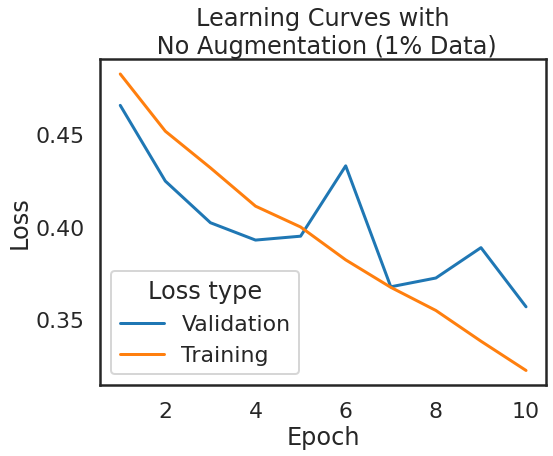

In [7]:
with open(path + "densenet_1_True_losses.pkl", "rb") as handle:
    results = pickle.load(handle)

plt.figure(figsize=(8,6))
df_val = pd.DataFrame({"Loss": results['val']})
df_val["Loss type"] = "Validation"
df_val["Epoch"] = list(range(1,11))
df_train = pd.DataFrame({"Loss": results['train']})
df_train["Loss type"] = "Training"
df_train["Epoch"] = list(range(1,11))
df = pd.concat([df_val, df_train])
sns.lineplot(x = "Epoch", y= "Loss", hue="Loss type", data=df)
plt.title('Learning Curves with\n No Augmentation (1% Data)')

Text(0.5, 1.0, 'Learning Curves with\n GAN Augmentation (1% Data)')

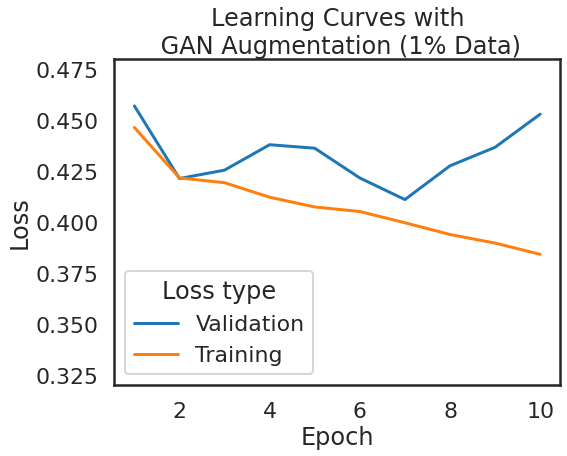

In [10]:
with open(path + "densenet_2_False_losses.pkl", "rb") as handle:
    results = pickle.load(handle)

plt.figure(figsize=(8,6))
df_val = pd.DataFrame({"Loss": results['val']})
df_val["Loss type"] = "Validation"
df_val["Epoch"] = list(range(1,11))
df_train = pd.DataFrame({"Loss": results['train']})
df_train["Loss type"] = "Training"
df_train["Epoch"] = list(range(1,11))
df = pd.concat([df_val, df_train])
sns.lineplot(x = "Epoch", y= "Loss", hue="Loss type", data=df)
plt.ylim((0.32, 0.48))
plt.title('Learning Curves with\n GAN Augmentation (1% Data)')

Text(0.5, 1.0, 'Learning Curves with\n No Augmentation (10% Data)')

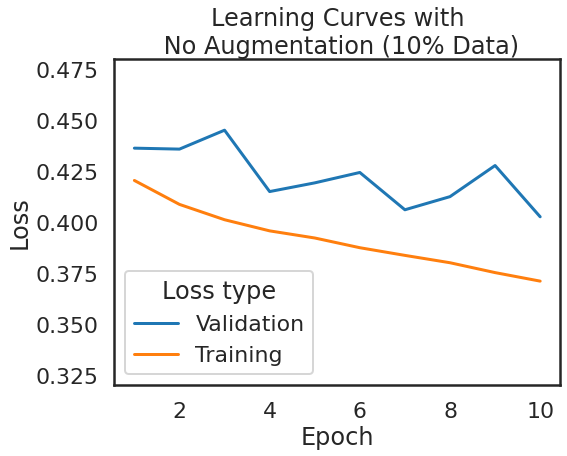

In [8]:
with open(path + "densenet_2_False_losses_10.pkl", "rb") as handle:
    results = pickle.load(handle)

plt.figure(figsize=(8,6))
df_val = pd.DataFrame({"Loss": results['val']})
df_val["Loss type"] = "Validation"
df_val["Epoch"] = list(range(1,11))
df_train = pd.DataFrame({"Loss": results['train']})
df_train["Loss type"] = "Training"
df_train["Epoch"] = list(range(1,11))
df = pd.concat([df_val, df_train])
sns.lineplot(x = "Epoch", y= "Loss", hue="Loss type", data=df)
plt.ylim((0.32, 0.48))
plt.title('Learning Curves with\n No Augmentation (10% Data)')

Text(0.5, 1.0, 'Learning Curves with\n GAN Augmentation (10% Data)')

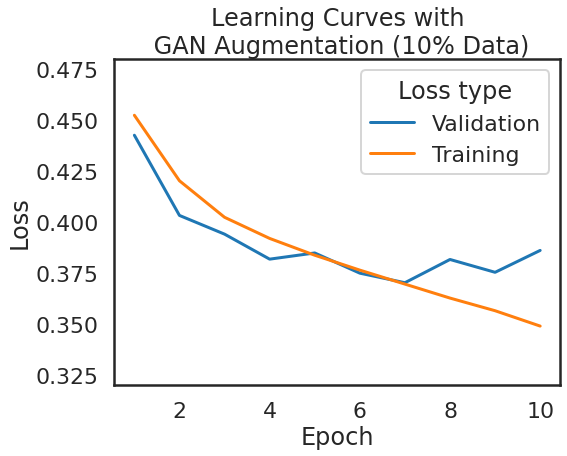

In [10]:
with open(path + "densenet_1_True_losses_10.pkl", "rb") as handle:
    results = pickle.load(handle)

plt.figure(figsize=(8,6))
df_val = pd.DataFrame({"Loss": results['val']})
df_val["Loss type"] = "Validation"
df_val["Epoch"] = list(range(1,11))
df_train = pd.DataFrame({"Loss": results['train']})
df_train["Loss type"] = "Training"
df_train["Epoch"] = list(range(1,11))
df = pd.concat([df_val, df_train])
sns.lineplot(x = "Epoch", y= "Loss", hue="Loss type", data=df)
plt.ylim((0.32, 0.48))
plt.title('Learning Curves with\n GAN Augmentation (10% Data)')